In [83]:
# Output all code in a chunk
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [133]:
# importing required libraries and functions
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # regular expression
from nltk import word_tokenize, PorterStemmer # natural language toolkit
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
import string

# performs exactly same as OneVsRestClassifier, using that instead
## from skmultilearn.problem_transform import BinaryRelevance

# not using as removed string.punctuations using re.sub function
## import string

import os

In [134]:
# download nltk packages
# nltk.download()

In [135]:
# reading data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [137]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total toxic tags =",x.sum())

143346

Total comments =  159571
Total clean comments =  143346
Total toxic tags = 35098


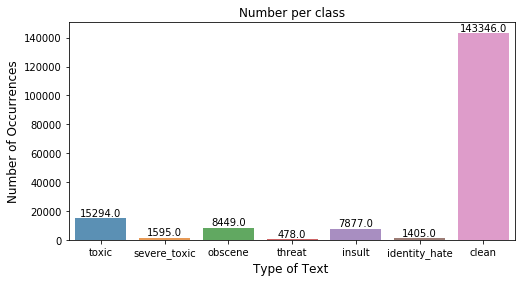

In [7]:
#check class imbalance
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Number per class")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type of Text ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

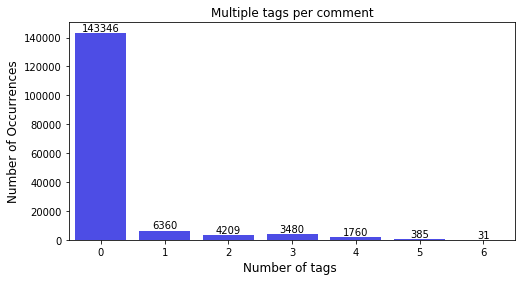

In [8]:
#check multi-tagging situation
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color='blue')
plt.title("Multiple tags per comment")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [9]:
#crosstab/confusion matrix of Toxic comments with the other classes
temp_df=train.iloc[:,2:-1]
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]
out = out.style.apply(highlight_min,axis=0)
out

Text(0.5,1,"Venn diagram for 'toxic', 'insult' and 'obscene'")

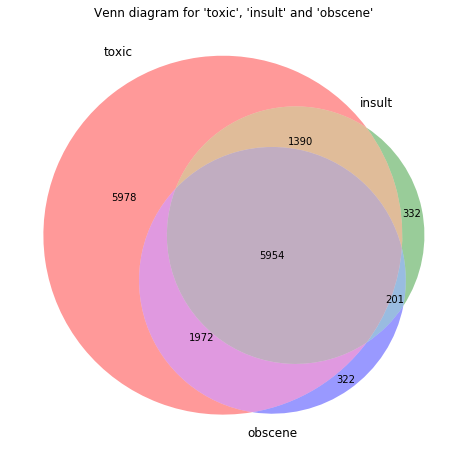

In [123]:
#Venn diagram for toxic, obscene,and insult
from matplotlib_venn import venn2
from matplotlib_venn import venn3
t = train[(train['toxic'] == 1) & (train['insult'] == 0) & (train['obscene'] == 0)].shape[0]
i = train[(train['toxic'] == 0) & (train['insult'] == 1) & (train['obscene'] == 0)].shape[0]
o = train[(train['toxic'] == 0) & (train['insult'] == 0) & (train['obscene'] == 1)].shape[0]

t_i = train[(train['toxic'] == 1) & (train['insult'] == 1) & (train['obscene'] == 0)].shape[0]
t_o = train[(train['toxic'] == 1) & (train['insult'] == 0) & (train['obscene'] == 1)].shape[0]
i_o = train[(train['toxic'] == 0) & (train['insult'] == 1) & (train['obscene'] == 1)].shape[0]

t_i_o = train[(train['toxic'] == 1) & (train['insult'] == 1) & (train['obscene'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o), 
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()

In [88]:
from wordcloud import WordCloud ,STOPWORDS
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

In [89]:
from PIL import Image
import codecs
from os import path

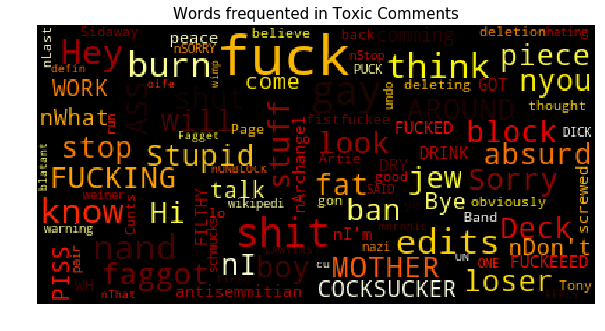

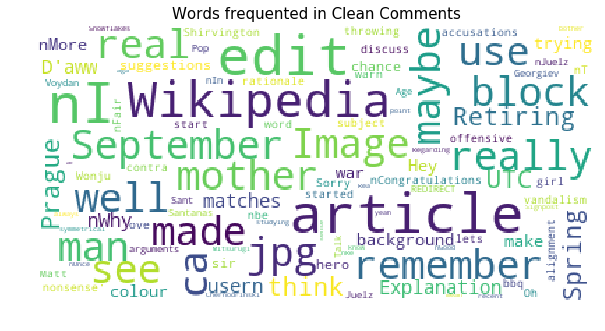

In [42]:
#wordcloud for toxic and clean comments
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=3000             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

#toxic
wc1 = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=100,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train['comment_text'][train['clean']==False]))
fig = plt.figure(figsize=(10,10))
plt.imshow(wc1)
plt.axis('off')
plt.title("Words frequented in Toxic Comments", fontsize=15)
plt.imshow(wc1.recolor(colormap= 'hot' , random_state=42), alpha=0.98)
plt.show()
fig.savefig("toxic_word.png", dpi=3000)

#clean
wc2 = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=100,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train['comment_text'][train['clean']==True]))
fig = plt.figure(figsize=(10,10))
plt.imshow(wc2)
plt.axis('off')
plt.title("Words frequented in Clean Comments", fontsize=15)

plt.show()
fig.savefig("clean_word.png", dpi=3000)



In [ ]:
#wordcloud for testing dataset
wc3 = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=100,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(test['comment_text']))
fig = plt.figure(figsize=(10,10))
plt.imshow(wc3)
plt.axis('off')
plt.title("Words frequented in test Comments", fontsize=15)

plt.show()
fig.savefig("test_word.png", dpi=3000)

Text(0.5,1,'Percentage of unique words of total words in comment')

Text(0.5,0,'Percent unique words')

Text(0.5,1,'Count of comments with low(<30%) unique words')

Text(0,340,'335.0')

Text(1,147,'142.0')

Text(2,232,'227.0')

Text(3,20,'15.0')

Text(4,199,'194.0')

Text(5,50,'45.0')

Text(6,133,'128.0')

Text(0.5,0,'Threat class')

Text(0,0.5,'Number of comments')

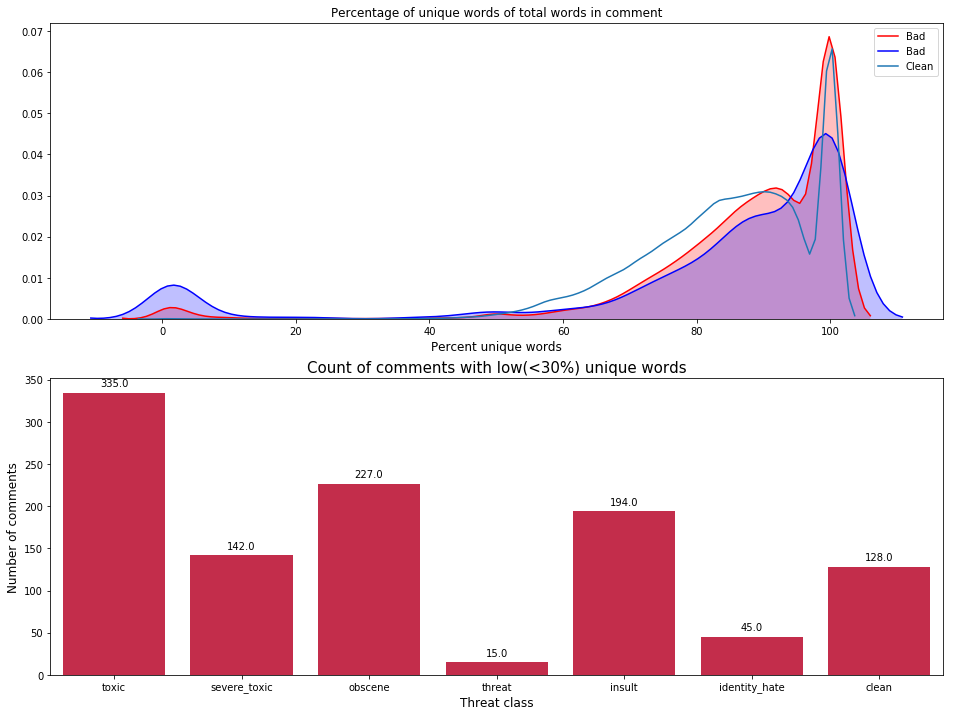

In [120]:
#check unique word
train['count_unique_word']=train["comment_text"].apply(lambda x: len(set(str(x).split())))
train['count_word']=train["comment_text"].apply(lambda x: len(str(x).split()))
train['word_unique_percent']=train['count_unique_word']*100/train['count_word']
spammers=train[train['word_unique_percent']<30]

plt.figure(figsize=(16,12))
#gridspec.GridSpec(2,1)


plt.subplot2grid((2,1),(0,0))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train[train.toxic == 1].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train[train.severe_toxic == 1].word_unique_percent, label="Bad",shade=True,color='b')

ax=sns.kdeplot(train[train.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,2:9].sum()
plt.subplot2grid((2,1),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color='crimson')

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('Number of comments', fontsize=12)
plt.show()

([<matplotlib.axis.XTick at 0x1f9a85f3048>,
 <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Average amount of punctuation in each comment category')

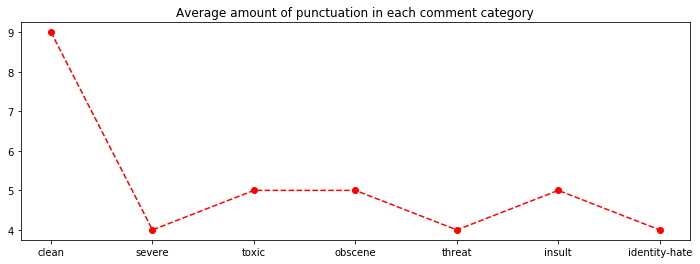

In [141]:
#Amount of punctuation in each comment category
train['punc_len'] = train["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
c2 = train.loc[train['clean']==1]['punc_len'].median()
s2 = train.loc[train['severe_toxic']==1]['punc_len'].median()
t2 = train.loc[train['toxic']==1]['punc_len'].median()
ob2 = train.loc[train['obscene']==1]['punc_len'].median()
th2 = train.loc[train['threat']==1]['punc_len'].median()
ins2 = train.loc[train['insult']==1]['punc_len'].median()
ih2 = train.loc[train['identity_hate']==1]['punc_len'].median()

cat2 = [c2,s2,t2,ob2,th2,ins2,ih2]


labels=['clean','severe','toxic','obscene','threat','insult','identity-hate']
order_of_labels = range(len(cat2))

plt.figure(figsize=(12,4))
plt.plot(cat2, 'r--', marker='o')
plt.xticks(order_of_labels, labels)
plt.title('Average amount of punctuation in each comment category')
plt.show()

<Container object of 7 artists>

([<matplotlib.axis.XTick at 0x1f9a4dbc278>,
 <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Average amount of personal pronoun in each comment category')

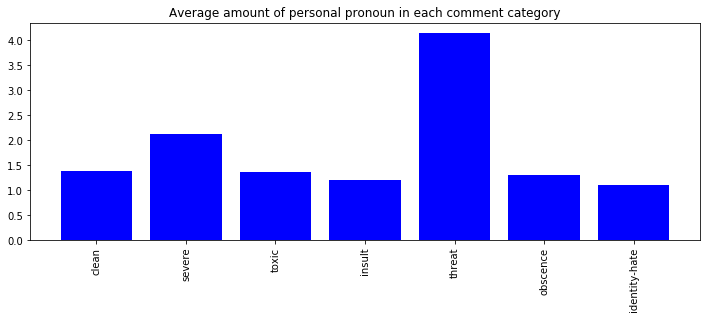

In [105]:
#Amount of Singular Personal Pronoun
train['len_I'] = train['comment_text'].apply(lambda x: len(re.findall(r"(\s+-?I\s)|(\s[iI]'m\s)|(\si\s)|(\s[iI]'d\s)|((\s[iI]'ve\s)|((\s[iI]'ll\s)))", str(x))))
CL = train.loc[train['clean']==1]['len_I'].mean()
SV = train.loc[train['severe_toxic']==1]['len_I'].mean()
TO = train.loc[train['toxic']==1]['len_I'].mean()
INS = train.loc[train['insult']==1]['len_I'].mean()
TH = train.loc[train['threat']==1]['len_I'].mean()
OB = train.loc[train['obscene']==1]['len_I'].mean()
IH = train.loc[train['identity_hate']==1]['len_I'].mean()
c_list = [CL, SV, TO, INS, TH, OB, IH]

labels=['clean','severe','toxic','insult','threat','obscence','identity-hate']
order_of_labels = range(len(c_list))

plt.figure(figsize=(12,4))
plt.bar(x=order_of_labels ,height=c_list, color='blue')
plt.xticks(order_of_labels, labels, rotation=90)
plt.title('Average amount of personal pronoun in each comment category')
plt.show()

<Container object of 7 artists>

([<matplotlib.axis.XTick at 0x1f9a5113f28>,
 <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Average ratio of nouns in each comment category')

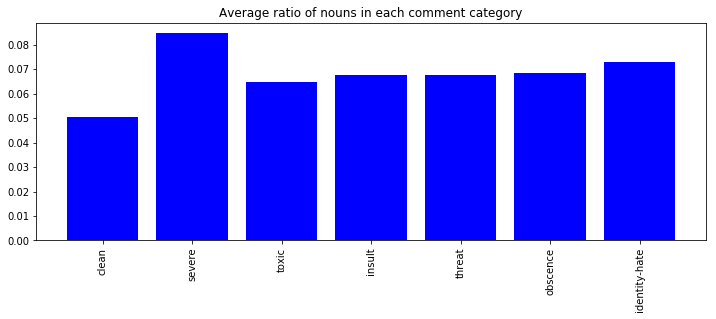

In [144]:
#Amount of noun, verb, adj
from nltk import pos_tag
def tag_part_of_speech(text):
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return[noun_count, adjective_count, verb_count]


train['nouns'], train['adjectives'], train['verbs'] = zip(*train['comment_text'].apply(
    lambda comment: tag_part_of_speech(comment)))
train['nouns_vs_length'] = train['nouns'] / train['total_length']
train['adjectives_vs_length'] = train['adjectives'] / train['total_length']
train['verbs_vs_length'] = train['verbs'] / train['total_length']

CL = train.loc[train['clean']==1]['nouns_vs_length'].mean()
SV = train.loc[train['severe_toxic']==1]['nouns_vs_length'].mean()
TO = train.loc[train['toxic']==1]['nouns_vs_length'].mean()
INS = train.loc[train['insult']==1]['nouns_vs_length'].mean()
TH = train.loc[train['threat']==1]['nouns_vs_length'].mean()
OB = train.loc[train['obscene']==1]['nouns_vs_length'].mean()
IH = train.loc[train['identity_hate']==1]['nouns_vs_length'].mean()
c_list = [CL, SV, TO, INS, TH, OB, IH]

labels=['clean','severe','toxic','insult','threat','obscence','identity-hate']
order_of_labels = range(len(c_list))

plt.figure(figsize=(12,4))
plt.bar(x=order_of_labels ,height=c_list, color='blue')
plt.xticks(order_of_labels, labels, rotation=90)
plt.title('Average ratio of nouns in each comment category')
plt.show()

<Container object of 7 artists>

([<matplotlib.axis.XTick at 0x1f9a7e3b978>,
 <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Average ratio of adjectives in each comment category')

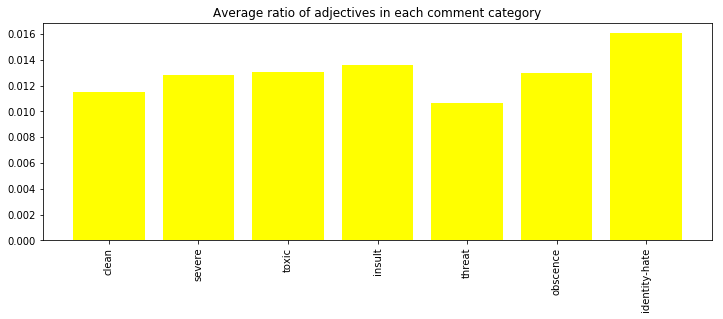

In [145]:
CL = train.loc[train['clean']==1]['adjectives_vs_length'].mean()
SV = train.loc[train['severe_toxic']==1]['adjectives_vs_length'].mean()
TO = train.loc[train['toxic']==1]['adjectives_vs_length'].mean()
INS = train.loc[train['insult']==1]['adjectives_vs_length'].mean()
TH = train.loc[train['threat']==1]['adjectives_vs_length'].mean()
OB = train.loc[train['obscene']==1]['adjectives_vs_length'].mean()
IH = train.loc[train['identity_hate']==1]['adjectives_vs_length'].mean()
c_list = [CL, SV, TO, INS, TH, OB, IH]

labels=['clean','severe','toxic','insult','threat','obscence','identity-hate']
order_of_labels = range(len(c_list))

plt.figure(figsize=(12,4))
plt.bar(x=order_of_labels ,height=c_list, color='yellow')
plt.xticks(order_of_labels, labels, rotation=90)
plt.title('Average ratio of adjectives in each comment category')
plt.show()

<Container object of 7 artists>

([<matplotlib.axis.XTick at 0x1fb7694df60>,
 <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Average ratio of verbs in each comment category')

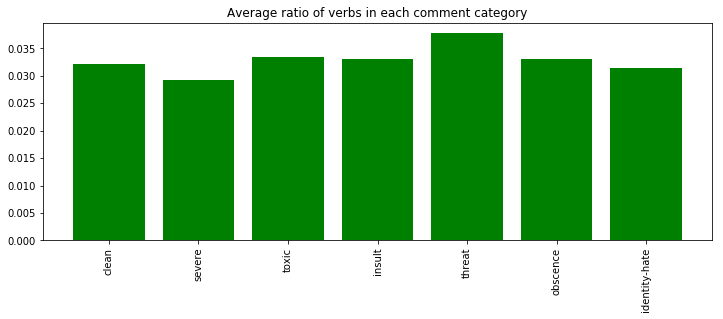

In [146]:
CL = train.loc[train['clean']==1]['verbs_vs_length'].mean()
SV = train.loc[train['severe_toxic']==1]['verbs_vs_length'].mean()
TO = train.loc[train['toxic']==1]['verbs_vs_length'].mean()
INS = train.loc[train['insult']==1]['verbs_vs_length'].mean()
TH = train.loc[train['threat']==1]['verbs_vs_length'].mean()
OB = train.loc[train['obscene']==1]['verbs_vs_length'].mean()
IH = train.loc[train['identity_hate']==1]['verbs_vs_length'].mean()
c_list = [CL, SV, TO, INS, TH, OB, IH]

labels=['clean','severe','toxic','insult','threat','obscence','identity-hate']
order_of_labels = range(len(c_list))

plt.figure(figsize=(12,4))
plt.bar(x=order_of_labels ,height=c_list, color='green')
plt.xticks(order_of_labels, labels, rotation=90)
plt.title('Average ratio of verbs in each comment category')
plt.show()

<Container object of 7 artists>

([<matplotlib.axis.XTick at 0x1f9a8642128>,
 <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Average capitals per length in each comment category')

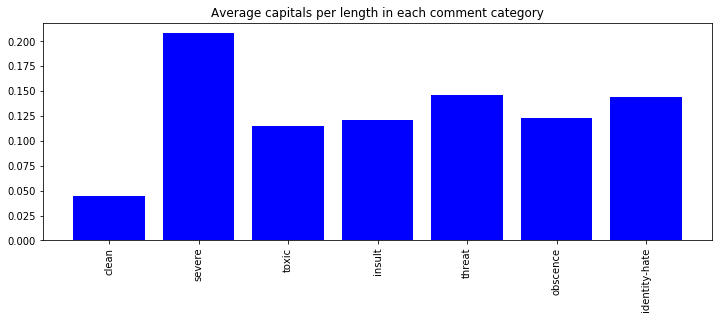

In [138]:
#Capitals vs length
train['total_length'] = train['comment_text'].apply(len)
train['capitals'] = train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train['capitals_vs_length'] = train['capitals'] / train['total_length']

CL = train.loc[train['clean']==1]['capitals_vs_length'].mean()
SV = train.loc[train['severe_toxic']==1]['capitals_vs_length'].mean()
TO = train.loc[train['toxic']==1]['capitals_vs_length'].mean()
INS = train.loc[train['insult']==1]['capitals_vs_length'].mean()
TH = train.loc[train['threat']==1]['capitals_vs_length'].mean()
OB = train.loc[train['obscene']==1]['capitals_vs_length'].mean()
IH = train.loc[train['identity_hate']==1]['capitals_vs_length'].mean()
c_list = [CL, SV, TO, INS, TH, OB, IH]

labels=['clean','severe','toxic','insult','threat','obscence','identity-hate']
order_of_labels = range(len(c_list))

plt.figure(figsize=(12,4))
plt.bar(x=order_of_labels ,height=c_list, color='blue')
plt.xticks(order_of_labels, labels, rotation=90)
plt.title('Average capitals per length in each comment category')
plt.show()